### Import library

In [1]:
%matplotlib notebook
# %load_ext autoreload
# %autoreload 2
#%matplotlib qt 


### Select Dataset 


In [2]:
# !pip install moabb[full]
# !pip install braindecode
# !pip install matplotlib==3.7.1
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [3]:
# # itemname is one of : ['BNCI2014004', 'BNCI2014001', 'Weibo2014', 'Physionet']
# itemname = 'BNCI2014004'
# filename = dname[itemname]
# iname = itemname + '__'    

# Load datasets

In [1]:
from nu_smrutils import loaddat
import pandas as pd
import pickle
import os
from sklearn.model_selection import train_test_split
import torch
import mne
import torcheeg.datasets
import torcheeg.datasets.moabb
import torcheeg.transforms as transforms


from moabb.datasets import (
    BNCI2014001, 
    BNCI2014004, 
    PhysionetMI, 
    Weibo2014
)
from moabb.paradigms import LeftRightImagery, LeftRightImagery
from nu_smrutils import load_pooled, augment_dataset, crop_data

# Preprocesses datasets and saves the results locally.
# If local copyis available, returns
class EEGDatasets:
    # 
    def __init__(self, local_dir=None):
        self.local_dir = local_dir or os.path.join(os.getcwd(), 'eeg-data')
    
    def moabb_dataset(self, name, subjects):
        if  name == 'BNCI2014001':
            raw_dataset = BNCI2014001()
            paradigm = LeftRightImagery()
            X, labels, meta = paradigm.get_data(dataset=raw_dataset, subjects=subjects, return_epochs=True)
            X.compute_psd().plot()
            print(type(X))
            assert False
            return X, labels
        elif  name == 'BNCI2014004':
            raw_dataset = BNCI2014004()
            paradigm = LeftRightImagery()
            X, labels, meta = paradigm.get_data(dataset=raw_dataset, subjects=subjects)
            return X, labels
        else:
            raise ValueError(f'unknown dataset name {name}')

datasets = EEGDatasets()        
itemname = 'BNCI2014001'
iname = itemname + '__'
raw_dataset = BNCI2014001()
# paradigm = MotorImagery(4)
paradigm = LeftRightImagery()
X, labels, meta = paradigm.get_data(dataset=raw_dataset, subjects=None, return_epochs=True)
print(f'info: {X.info}')
print(f'X: {X}')
print(f'len: {len(X)}')
print(f'shape: {X.get_data().shape}')
print(f'shape: {X[0].get_data().shape}')


io_path = os.path.join(os.getcwd(), 
                       f'moabb_BNCI2014004')            
m_dataset = torcheeg.datasets.moabb.MOABBDataset(
            dataset=raw_dataset,
            paradigm=paradigm,
            io_path=io_path,
            in_memory=True,
            online_transform=transforms.Compose([
                transforms.Downsample(321),
                transforms.ToTensor(),
            ]),
            label_transform=transforms.Compose([
                transforms.Select('label'),
                transforms.Lambda(lambda x: {'left_hand': 0,'right_hand': 1}[x]),
            ]))


def make_tensor_ds(ds):
    device = torch.device('cuda:0')
    data, labels = [], []
    for d, l in ds:
        data.append(d)
        labels.append(torch.tensor(l, dtype=torch.int64))
    data, labels = torch.stack(data), torch.stack(labels)
    events, counts = torch.unique(labels, return_counts=True)
    return (data, labels,
            dict(zip(events.tolist(), counts.tolist())))




# psd = X.compute_psd()
# psd.plot()
# print(f'psd: {psd.get_data().shape}')
print(type(X))
# data, labels = datasets.moabb_dataset(itemname, [1])

print(X.get_data().shape)
print(f'{X.get_data().shape=}')
print(f'{labels.shape=}')
# X.plot()
data = X.get_data()
m_data, m_labels, stats = make_tensor_ds(m_dataset)
print(f'{m_data.shape=}')
print(f'{m_labels.shape=}')


def load_pooled1(data, labels, test_size=0.15):
    """
    Creates pooled data from all subject specific EEG dataset.          

    Parameters:
    -------------------------
    Input: a python list containing MNE EEG data objects. 

    For instance, a list with the following elements:    
    [<Epochs  |   720 events, 'left_hand': 360  'right_hand': 360>,
     <Epochs   |  680 events, 'left_hand': 340, 'right_hand': 340>]

    Returns:
    -------------------------
    A dictionary :
        X_train, X_valid, X_test: 
        np.array of shape >>>  (samples, channel, times), 

        Data labels: 
        y_train, y_valid, y_test
    -------------------------
    output = dict(xtrain = X_train, xvalid = X_valid, xtest = X_test,
                  ytrain = y_train, yvalid = y_valid, ytest = y_test)
    -------------------------    
    """

    X = data
    Y = labels.numpy().astype(int)
#     Y = (labels == 'right_hand').astype(int)

    # split the data using sklearn split function
    x_rest, x_test, y_rest, y_test =\
        train_test_split(X, Y, test_size=test_size, random_state=42,
                         stratify=Y)

    x_train, x_valid, y_train, y_valid =\
        train_test_split(x_rest, y_rest, test_size=0.2, random_state=42,
                         stratify=y_rest)

    # Convert to Pytorch tensors
    X_train, X_valid, X_test = map(torch.tensor, (x_train, x_valid, x_test))
    y_train, y_valid, y_test = map(torch.tensor, (y_train, y_valid, y_test))

    return dict(xtrain=X_train, xvalid=X_valid, xtest=X_test,
                ytrain=y_train, yvalid=y_valid, ytest=y_test)

dat = load_pooled1(m_data, m_labels, test_size = 0.15)
print(f'before cropping: {dat["xtrain"].shape=}')
print(f'before cropping: {dat["xtest"].shape=}')
print(f'before cropping: {dat["xvalid"].shape=}')


augdata = dict(std_dev = 0.01, multiple = 2)

# xtrain, ytrain = augment_dataset(dat['xtrain'], dat['ytrain'], 
#                                  augdata['std_dev'], augdata['multiple'])

# print("Shape after data augmentation :", xtrain.shape)
# dat['xtrain'], dat['ytrain'] = xtrain, ytrain

fs = 80 # sampling frequency 
crop_len = 1.5 #or None
crop = dict(fs = fs, crop_len = crop_len)

#if crop['crop_len']:
X_train,y_train = crop_data(crop['fs'],crop['crop_len'], 
                            dat['xtrain'], dat['ytrain'], 
                            xpercent = 50)

X_valid,y_valid = crop_data(crop['fs'],crop['crop_len'], 
                            dat['xvalid'], dat['yvalid'], 
                            xpercent = 50)

X_test, y_test  = crop_data(crop['fs'],crop['crop_len'], 
                            dat['xtest'], dat['ytest'], 
                            xpercent = 50)

print(f'data shape after cropping {X_train.shape=}')
print(f'data shape after cropping {y_train.shape=}')


# X_train,y_train = (dat['xtrain'], dat['ytrain'])

# X_valid,y_valid = (dat['xvalid'], dat['yvalid'])

# X_test, y_test  = (dat['xtest'], dat['ytest'])

dat = dict(xtrain = X_train, xvalid = X_valid, xtest = X_test,
           ytrain = y_train, yvalid = y_valid, ytest = y_test)

print('data shape after cropping :',dat['xtrain'].shape)

# print(dat['xtrain'].max(), dat['xtrain'].min())
# print(dat['xtest'].max(), dat['xtest'].min())
# print(dat['xvalid'].max(), dat['xvalid'].min())
                    

Tensorflow not install, you could not use those pipelines
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
A

No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction applied
Adding metadata with 3 columns
Not setting metadata
24 matching events found
No baseline correction appli

### Pytorch dataloaders 

In [2]:
import torch 
from torch.utils.data import TensorDataset, DataLoader  

def get_data_loaders(dat, batch_size, EEGNET = None):    
    # convert data dimensions to into to gray scale image format
    if EEGNET: ### EEGNet model requires the last dimension to be 1 
        ff = lambda dat: torch.unsqueeze(dat, dim = -1)    
    else:
        ff = lambda dat: torch.unsqueeze(dat, dim = 1)    
    
    x_train, x_valid, x_test = map(ff,(dat['xtrain'], dat['xvalid'],dat['xtest']))    
    y_train, y_valid, y_test = dat['ytrain'], dat['yvalid'], dat['ytest']
    print('Input data shape', x_train.shape)       
    
    # TensorDataset & Dataloader    
    train_dat    = TensorDataset(x_train, y_train) 
    val_dat      = TensorDataset(x_valid, y_valid) 
    
    train_loader = DataLoader(train_dat, batch_size = batch_size, shuffle = True)
    val_loader   = DataLoader(val_dat,   batch_size = batch_size, shuffle = False)

    output = dict(dset_loaders = {'train': train_loader, 'val': val_loader}, 
                  dset_sizes  =  {'train': len(x_train), 'val': len(x_valid)},
                  test_data   =  {'x_test' : x_test, 'y_test' : y_test})          
    return output 

In [3]:
dat = get_data_loaders(dat, batch_size = 64)
dat.keys()

Input data shape torch.Size([3524, 1, 22, 180])


dict_keys(['dset_loaders', 'dset_sizes', 'test_data'])

In [4]:
# Sanity check begin 
dset_loaders = dat['dset_loaders']
dset_sizes = dat['dset_sizes']
dset_sizes

dtrain = dset_loaders['train']
dval   = dset_loaders['val']

dtr = iter(dtrain)
dv  = iter(dval)

In [5]:
inputs, labels = next(dtr)
print(inputs.shape, labels.shape)
# Sanity check end 

torch.Size([64, 1, 22, 180]) torch.Size([64])


## CNN model

In [6]:
import torch.nn as nn
import numpy as np

class CNN2D(torch.nn.Module):  
    def __init__(self, input_size, kernel_size, conv_channels, 
                 dense_size, dropout):         
        super(CNN2D, self).__init__()                  
        self.cconv   = []  
        self.MaxPool = nn.MaxPool2d((1, 2), (1, 2))  
        self.ReLU    = nn.ReLU()
        self.Dropout = nn.Dropout(dropout)        
        self.batchnorm = []
        # ############ batchnorm ###########
        for jj in conv_channels:
            self.batchnorm.append(nn.BatchNorm2d(jj, eps=0.001, momentum=0.01,
                                                 affine=True, track_running_stats=True).cuda())     
        ii = 0 ##### define CONV layer architecture: #####
        for in_channels, out_channels in zip(conv_channels, conv_channels[1:]):                           
            conv_i = torch.nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                     kernel_size = kernel_size[ii], #stride = (1, 2),
                                     padding     = (kernel_size[ii][0]//2, kernel_size[ii][1]//2))            
            self.cconv.append(conv_i)                
            self.add_module('CNN_K{}_O{}'.format(kernel_size[ii], out_channels), conv_i)
            ii += 1                            
            print(f'conv channels: {conv_channels}')
        self.flat_dim = self.get_output_dim(input_size, self.cconv)    
        self.fc1 = torch.nn.Linear(self.flat_dim, dense_size)
        self.fc2 = torch.nn.Linear(dense_size, 2)                

    def get_output_dim(self, input_size, cconv):        
        with torch.no_grad():
            input = torch.ones(1,*input_size)              
            for conv_i in cconv:                
                input = self.MaxPool(conv_i(input))        
                flatout = int(np.prod(input.size()[1:]))
                print("Input shape : {} and flattened : {}".format(input.shape, flatout))
        return flatout 
        
    def forward(self, input):        
        for jj, conv_i in enumerate(self.cconv):
            input = conv_i(input)
            input = self.batchnorm[jj+1](input)
            input = self.ReLU(input)        
            input = self.MaxPool(input)                   
        # flatten the CNN output     
        out = input.view(-1, self.flat_dim) 
        out = self.fc1(out)
        out = self.ReLU(out)
        out = self.Dropout(out)        
        out = self.fc2(out)      
        return out        

### Hyperparameter settings

In [7]:
import torch 
torch.manual_seed(0)

from nu_smrutils import train_model  

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if dev.type == 'cuda':
   print('Your GPU device name :', torch.cuda.get_device_name())

Your GPU device name : NVIDIA GeForce RTX 2080


In [8]:
num_epochs = 150 
learning_rate = 1e-3
weight_decay = 1e-4  
batch_size = 64
verbose = 1

#% used to save the results table 
results = {}        
table = pd.DataFrame(columns = ['Train_Acc', 'Val_Acc', 'Test_Acc', 'Epoch'])   

#% get input size (channel x timepoints)
input_size = (1, dat['test_data']['x_test'].shape[-2], 
                 dat['test_data']['x_test'].shape[-1])
print(input_size)

(1, 22, 180)


Relate the **kernel width** hyperparameter to a temporal window in milliseconds    

- If we want to convolve 100 ms >>> set time_window = 100 #ms
- width = (time_window_of_interest * sampling_frequency)/one_second 

In [9]:
# define kernel size in terms of ms length 
fs = 80 #Hz
time_window = 100 #ms
width = time_window*fs//1000  

# width = 8 #timelength//chans         
# convolution parameters 
h1, w1 = 3, 1
h2, w2 = 3, 3
h3, w3 = 3, 5       

In [10]:
# one should run this script twice with ConvDown = True or False 
# to have different convolutional layer patterns  
ConvDOWN = True  

if ConvDOWN:            
    params = {'conv_channels': [
                                [1, 16, 8],                                               
                                [1, 32, 16, 8],
                                [1, 64, 32, 16, 8],
                                [1, 128, 64, 32, 16, 8],
                                [1, 256, 128, 64, 32, 16, 8]                                     
                                ],                         

              'kernel_size':    [[(h1, w1*width), (h1, w1*width), (h1, w1*width),
                                  (h1, w1*width), (h1, w1*width), (h1, w1*width)],
                                 
                                 [(h2, w2*width), (h2, w2*width), (h2, w2*width),
                                  (h2, w2*width),(h2, w2*width), (h2, w2*width)],
                                 
                                 [(h3, w3*width), (h3, w3*width), (h3, w3*width),
                                  (h3, w3*width), (h3, w3*width),(h3, w3*width)]]                                                                      
              }                      
else:                      
    params = {'conv_channels': [
                                [1, 8, 16],                                                  
                                [1, 8, 16, 32],
                                [1, 8, 16, 32, 64],
                                [1, 8, 16, 32, 64, 128],
                                [1, 8, 16, 32, 64, 128, 256]
                                ],      		

              'kernel_size':    [[(h1, w1*width), (h1, w1*width), (h1, w1*width),
                                  (h1, w1*width), (h1, w1*width), (h1, w1*width)],
                                 
                                 [(h2, w2*width), (h2, w2*width), (h2, w2*width),
                                  (h2, w2*width), (h2, w2*width), (h2, w2*width)],
                                 
                                 [(h3, w3*width), (h3, w3*width), (h3, w3*width),
                                  (h3, w3*width), (h3, w3*width), (h3, w3*width)]]                     
              }    
keys = list(params)

------------
## Training loop 

In [11]:
import itertools

In [ ]:
for values in itertools.product(*map(params.get, keys)):
    d = dict(zip(keys, values))    
    description = 'C{}_K{}'.format(d['conv_channels'], d['kernel_size'][0])    
    print('\n\n##### ' + description + ' #####')

    # Define the architecture
    model = CNN2D(input_size    = input_size,
                  kernel_size   = d['kernel_size'], 
                  conv_channels = d['conv_channels'],
                  dense_size    = 256,
                  dropout       = 0.5)               
    print("Model architecture >>>", model)

    # optimizer and the loss function definition 
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    # move the model to GPU/CPU
    model.to(dev)  
    criterion.to(dev)       

    #******** Training loop *********    
    best_model, train_losses, val_losses, train_accs, val_accs, info =\
        train_model(model, dat['dset_loaders'], dat['dset_sizes'], 
                    criterion, optimizer, dev, lr_scheduler = None, 
                    num_epochs = num_epochs, verbose = verbose)    

    test_samples = 100
    x_test = dat['test_data']['x_test'][:test_samples,:,:,:] 
    y_test = dat['test_data']['y_test'][:test_samples] 
    
    # predict test data 
    preds = best_model(x_test.to(dev, dtype=torch.float)) 
    preds_class = preds.data.max(1)[1]

    # get the accuracy 
    corrects = torch.sum(preds_class == y_test.data.to(dev))     
    test_acc = corrects.cpu().numpy()/x_test.shape[0]
    print("Test Accuracy :", test_acc) 

    # save results       
    tab = dict(Train_Acc= train_accs[info['best_epoch']],
               Val_Acc  = val_accs[info['best_epoch']],   
               Test_Acc = test_acc, Epoch = info['best_epoch'] + 1)         

    table.loc[description] = tab  
    val_acc = np.max(val_accs)

    print(table)
    results[description] = dict(train_accs = train_accs, val_accs =  val_accs,                                
                                ytrain = info['ytrain'], yval= info['yval'])      
    
    # save the best model weights
    fname = 'm_' + iname + 'CNN_POOLED' + description + '_' + str(val_acc)[:4]
    torch.save(best_model.state_dict(), fname) 



##### C[1, 16, 8]_K(3, 8) #####
conv channels: [1, 16, 8]
conv channels: [1, 16, 8]
Input shape : torch.Size([1, 16, 22, 90]) and flattened : 31680
Input shape : torch.Size([1, 8, 22, 45]) and flattened : 7920
Model architecture >>> CNN2D(
  (MaxPool): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (ReLU): ReLU()
  (Dropout): Dropout(p=0.5, inplace=False)
  (CNN_K(3, 8)_O16): Conv2d(1, 16, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (CNN_K(3, 8)_O8): Conv2d(16, 8, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (fc1): Linear(in_features=7920, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)
num_epoch:  150
Training complete in 1m 5s
Best val Acc: 0.678005
Best Epoch : 56
Test Accuracy : 0.69
                     Train_Acc   Val_Acc  Test_Acc  Epoch
C[1, 16, 8]_K(3, 8)    0.62202  0.678005      0.69     56


##### C[1, 16, 8]_K(3, 24) #####
conv channels: [1, 16, 8]
conv channels: [1, 16, 8

### Save results

In [ ]:
import pickle

In [ ]:
rTable = dict(table = table)
ij = str(np.random.randint(101))
filename = iname + "_CNNPOOLEDRES_"+description +ij+ 'ConvDown' + str(ConvDOWN)         

with open(filename, 'wb') as ffile:
    pickle.dump(rTable, ffile)   

### Results obtained

In [ ]:
rTable['table']

In [82]:
"""
Demo single-file script to train a ConvNet on CIFAR10 using SoftHebb, an unsupervised, efficient and bio-plausible
learning algorithm
"""
import math
from typing import Any
import warnings

import torch
from torch.utils.data import Dataset
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import StepLR
import torchvision

class SoftHebbConv2d(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int = 1,
            padding: int = 0,
            dilation: int = 1,
            groups: int = 1,
            t_invert: float = 12,
    ) -> None:
        """
        Simplified implementation of Conv2d learnt with SoftHebb; an unsupervised, efficient and bio-plausible
        learning algorithm.
        This simplified implementation omits certain configurable aspects, like using a bias, groups>1, etc. which can
        be found in the full implementation in hebbconv.py
        """
        super(SoftHebbConv2d, self).__init__()
        assert groups == 1, "Simple implementation does not support groups > 1."
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.dilation = _pair(dilation)
        self.groups = groups
        self.padding_mode = 'reflect'
        self.F_padding = (padding, padding, padding, padding)
        weight_range = 25 / math.sqrt((in_channels / groups) * kernel_size * kernel_size)
        self.weight = nn.Parameter(weight_range * torch.randn((out_channels, in_channels // groups, *self.kernel_size)))
        self.t_invert = torch.tensor(t_invert)

    def forward(self, x):
        x = F.pad(x, self.F_padding, self.padding_mode)  # pad input
        # perform conv, obtain weighted input u \in [B, OC, OH, OW]
        weighted_input = F.conv2d(x, self.weight, None, self.stride, 0, self.dilation, self.groups)

        if self.training:
            # ===== find post-synaptic activations y = sign(u)*softmax(u, dim=C), s(u)=1 - 2*I[u==max(u,dim=C)] =====
            # Post-synaptic activation, for plastic update, is weighted input passed through a softmax.
            # Non-winning neurons (those not with the highest activation) receive the negated post-synaptic activation.
            batch_size, out_channels, height_out, width_out = weighted_input.shape
            # Flatten non-competing dimensions (B, OC, OH, OW) -> (OC, B*OH*OW)
            flat_weighted_inputs = weighted_input.transpose(0, 1).reshape(out_channels, -1)
            # Compute the winner neuron for each batch element and pixel
            flat_softwta_activs = torch.softmax(self.t_invert * flat_weighted_inputs, dim=0)
            flat_softwta_activs = - flat_softwta_activs  # Turn all postsynaptic activations into anti-Hebbian
            win_neurons = torch.argmax(flat_weighted_inputs, dim=0)  # winning neuron for each pixel in each input
            competing_idx = torch.arange(flat_weighted_inputs.size(1))  # indeces of all pixel-input elements
            # Turn winner neurons' activations back to hebbian
            flat_softwta_activs[win_neurons, competing_idx] = - flat_softwta_activs[win_neurons, competing_idx]
            softwta_activs = flat_softwta_activs.view(out_channels, batch_size, height_out, width_out).transpose(0, 1)
            # ===== compute plastic update Δw = y*(x - u*w) = y*x - (y*u)*w =======================================
            # Use Convolutions to apply the plastic update. Sweep over inputs with postynaptic activations.
            # Each weighting of an input pixel & an activation pixel updates the kernel element that connected them in
            # the forward pass.
            yx = F.conv2d(
                x.transpose(0, 1),  # (B, IC, IH, IW) -> (IC, B, IH, IW)
                softwta_activs.transpose(0, 1),  # (B, OC, OH, OW) -> (OC, B, OH, OW)
                padding=0,
                stride=self.dilation,
                dilation=self.stride,
                groups=1
            ).transpose(0, 1)  # (IC, OC, KH, KW) -> (OC, IC, KH, KW)

            # sum over batch, output pixels: each kernel element will influence all batches and output pixels.
            yu = torch.sum(torch.mul(softwta_activs, weighted_input), dim=(0, 2, 3))
            delta_weight = yx - yu.view(-1, 1, 1, 1) * self.weight
            delta_weight.div_(torch.abs(delta_weight).amax() + 1e-30)  # Scale [min/max , 1]
            self.weight.grad = delta_weight  # store in grad to be used with common optimizers

        return weighted_input


class DeepSoftHebb(nn.Module):
    def __init__(self):
        super(DeepSoftHebb, self).__init__()
#         # block 1
#         self.bn1 = nn.BatchNorm2d(3, affine=False)
#         self.conv1 = SoftHebbConv2d(in_channels=3, out_channels=96, kernel_size=5, padding=2, t_invert=1,)
#         self.activ1 = Triangle(power=0.7)
#         self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
#         # block 2
#         self.bn2 = nn.BatchNorm2d(96, affine=False)
#         self.conv2 = SoftHebbConv2d(in_channels=96, out_channels=384, kernel_size=3, padding=1, t_invert=0.65,)
#         self.activ2 = Triangle(power=1.4)
#         self.pool2 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
#         # block 3
#         self.bn3 = nn.BatchNorm2d(384, affine=False)
#         self.conv3 = SoftHebbConv2d(in_channels=384, out_channels=1536, kernel_size=3, padding=1, t_invert=0.25,)
#         self.activ3 = Triangle(power=1.)
#         self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
#         # block 4
#         self.flatten = nn.Flatten()
#         self.classifier = nn.Linear(24576, 10)
#         self.classifier.weight.data = 0.11048543456039805 * torch.rand(10, 24576)
#         self.dropout = nn.Dropout(0.5)
        
        # block 1
        self.bn1 = nn.BatchNorm2d(1, affine=False)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=5, padding=2)#, t_invert=1,)
        self.activ1 = Triangle(power=0.7)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
        # block 2
        self.bn2 = nn.BatchNorm2d(96, affine=False)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=384, kernel_size=3, padding=1)#, t_invert=0.65,)
        self.activ2 = Triangle(power=1.4)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
        # block 3
        self.flatten = nn.Flatten()
        LINEAR_IN, LINEAR_OUT = 86400, 1
        self.classifier = nn.Linear(LINEAR_IN, LINEAR_OUT)
        #self.classifier.weight.data = 0.11048543456039805 * torch.rand(LINEAR_OUT, LINEAR_IN)
        self.dropout = nn.Dropout(0.5)
        self.final_activ = nn.Sigmoid()

    def forward(self, x):
        # block 1
        out = self.pool1(self.activ1(self.conv1(self.bn1(x))))
        # block 2
        out = self.pool2(self.activ2(self.conv2(self.bn2(out))))
#         # block 3
#         out = self.pool3(self.activ3(self.conv3(self.bn3(out))))
#         block 4
        return torch.squeeze(self.final_activ(self.classifier(self.dropout(self.flatten(out)))), -1)


# class DeepSoftHebb(nn.Module):
#     def __init__(self):
#         super(DeepSoftHebb, self).__init__()
#         # block 1
#         self.bn1 = nn.BatchNorm2d(3, affine=False)
#         self.conv1 = SoftHebbConv2d(in_channels=3, out_channels=96, kernel_size=5, padding=2, t_invert=1,)
#         self.activ1 = Triangle(power=0.7)
#         self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
#         # block 2
#         self.bn2 = nn.BatchNorm2d(96, affine=False)
#         self.conv2 = SoftHebbConv2d(in_channels=96, out_channels=384, kernel_size=3, padding=1, t_invert=0.65,)
#         self.activ2 = Triangle(power=1.4)
#         self.pool2 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
#         # block 3
#         self.bn3 = nn.BatchNorm2d(384, affine=False)
#         self.conv3 = SoftHebbConv2d(in_channels=384, out_channels=1536, kernel_size=3, padding=1, t_invert=0.25,)
#         self.activ3 = Triangle(power=1.)
#         self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
#         # block 4
#         self.flatten = nn.Flatten()
#         self.classifier = nn.Linear(24576, 10)
#         self.classifier.weight.data = 0.11048543456039805 * torch.rand(10, 24576)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         # block 1
#         out = self.pool1(self.activ1(self.conv1(self.bn1(x))))
#         # block 2
#         out = self.pool2(self.activ2(self.conv2(self.bn2(out))))
#         # block 3
#         out = self.pool3(self.activ3(self.conv3(self.bn3(out))))
#         # block 4
#         return self.classifier(self.dropout(self.flatten(out)))

class Triangle(nn.Module):
    def __init__(self, power: float = 1, inplace: bool = True):
        super(Triangle, self).__init__()
        self.inplace = inplace
        self.power = power

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        input = input - torch.mean(input.data, axis=1, keepdims=True)
        return F.relu(input, inplace=self.inplace) ** self.power


class WeightNormDependentLR(optim.lr_scheduler._LRScheduler):
    """
    Custom Learning Rate Scheduler for unsupervised training of SoftHebb Convolutional blocks.
    Difference between current neuron norm and theoretical converged norm (=1) scales the initial lr.
    """

    def __init__(self, optimizer, power_lr, last_epoch=-1, verbose=False):
        self.optimizer = optimizer
        self.initial_lr_groups = [group['lr'] for group in self.optimizer.param_groups]  # store initial lrs
        self.power_lr = power_lr
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        new_lr = []
        for i, group in enumerate(self.optimizer.param_groups):
            for param in group['params']:
                # difference between current neuron norm and theoretical converged norm (=1) scales the initial lr
                # initial_lr * |neuron_norm - 1| ** 0.5
                norm_diff = torch.abs(torch.linalg.norm(param.view(param.shape[0], -1), dim=1, ord=2) - 1) + 1e-10
                new_lr.append(self.initial_lr_groups[i] * (norm_diff ** self.power_lr)[:, None, None, None])
        return new_lr


class TensorLRSGD(optim.SGD):
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step, using a non-scalar (tensor) learning rate.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(-group['lr'] * d_p)
        return loss


class CustomStepLR(StepLR):
    """
    Custom Learning Rate schedule with step functions for supervised training of linear readout (classifier)
    """

    def __init__(self, optimizer, nb_epochs):
        threshold_ratios = [0.2, 0.35, 0.5, 0.6, 0.7, 0.8, 0.9]
        self.step_thresold = [int(nb_epochs * r) for r in threshold_ratios]
        super().__init__(optimizer, -1, False)

    def get_lr(self):
        if self.last_epoch in self.step_thresold:
            return [group['lr'] * 0.5
                    for group in self.optimizer.param_groups]
        return [group['lr'] for group in self.optimizer.param_groups]

In [83]:
class FastCIFAR10(torchvision.datasets.CIFAR10):
    """
    Improves performance of training on CIFAR10 by removing the PIL interface and pre-loading on the GPU (2-3x speedup).

    Taken from https://github.com/y0ast/pytorch-snippets/tree/main/fast_mnist
    """

    def __init__(self, *args, device='cpu', **kwargs: dict[str, Any]):
        super().__init__(*args, **kwargs)

        self.data = torch.tensor(self.data, dtype=torch.float, device=device).div_(255)
        self.data = torch.movedim(self.data, -1, 1)  # -> set dim to: (batch, channels, height, width)
        self.targets = torch.tensor(self.targets, device=device)
        #print(self.data)
        #print(self.targets)
        #assert False

    def __getitem__(self, index: int):
        """
        Parameters
        ----------
        index : int
            Index of the element to be returned

        Returns
        -------
            tuple: (image, target) where target is the index of the target class
        """ 
        img = self.data[index]
        target = self.targets[index]

        return img, target
    

class SimpleEEGDataset(Dataset):
    def __init__(self, data, labels, device='cpu'):
        #super().__init__()
        
        self.data = data.to(torch.float).div_(255).to(device)
#         self.data = torch.movedim(self.data, -1, 1)  # -> set dim to: (batch, channels, height, width)
        self.data = torch.unsqueeze(self.data, 1)
        self.labels =  labels.to(torch.float).to(device)
#         assert False
#         self.labels = torch.tens or(labels).type(torch.LongTensor)

        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index: int):
        """
        Parameters
        ----------
        index : int
            Index of the element to be returned

        Returns
        -------
            tuple: (image, target) where target is the index of the target class
        """ 
        img = self.data[index]
        labels = self.labels[index]
        return img, labels

    

In [84]:
# Main training loop CIFAR10
if __name__ == "__main__":
    device = torch.device('cuda:0')
    model = DeepSoftHebb()
    model.to(device)

    unsup_optimizer = TensorLRSGD([
        {"params": model.conv1.parameters(), "lr": -0.08, },  # SGD does descent, so set lr to negative
        {"params": model.conv2.parameters(), "lr": -0.005, },
#         {"params": model.con v3.parameters(), "lr": -0.01, },
    ], lr=0)
    unsup_lr_scheduler = WeightNormDependentLR(unsup_optimizer, power_lr=0.5)

    sup_optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sup_lr_scheduler = CustomStepLR(sup_optimizer, nb_epochs=50)
    criterion = nn.BCELoss()

#     trainset = FastCIFAR10('./data', train=True, download=True)
    trainset = SimpleEEGDataset(dat['xtrain'], dat['ytrain'])
#     trainset = FastCIFAR10('./data', train=True, download=True)
    unsup_trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
    sup_trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

#     testset = FastCIFAR10('./data', train=False)
    testset = SimpleEEGDataset(dat['xvalid'], dat['yvalid'])
#     testset = SimpleEEGDataset(dat['xtrain'], dat['ytrain'])
    testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

#     # Unsupervised training with SoftHebb
#     running_loss = 0.0
#     for i, data in enumerate(unsup_trainloader, 0):
#         inputs, _ = data
#         inputs = inputs.to(device)

#         # zero the parameter gradients
#         unsup_optimizer.zero_grad()

#         # forward + update computation
#         with torch.no_grad():
#             outputs = model(inputs)

#         # optimize
#         unsup_optimizer.step()
#         unsup_lr_scheduler.step()

#     # Supervised training of classifier
#     # set requires grad false and eval mode for all modules but classifier
#     unsup_optimizer.zero_grad()
#     model.conv1.requires_grad = False
#     model.conv2.requires_grad = False
# #     model.conv3.requires_grad = False
#     model.conv1.eval()
#     model.conv2.eval()
# #     model.conv3.eval()
#     model.bn1.eval()
#     model.bn2.eval()
#     model.bn3.eval()
    for epoch in range(50):
        model.classifier.train()
        model.dropout.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(sup_trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            sup_optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            sup_optimizer.step()

            # compute training statistics
            running_loss += loss.item()
            if epoch % 10 == 0 or epoch == 49:
                total += labels.size(0)
                #_, predicted = torch.max(outputs, 1)
                predicted = outputs.round()
                print(f'train predicted: {predicted}')
                print(f'train outputs: {outputs}')    
                correct += (predicted == labels).sum().item()
        sup_lr_scheduler.step()
        # Evaluation on test set
        if epoch % 10 == 0 or epoch == 49:
            print(f'Accuracy of the network on the train images: {100 * correct // total} %')
            print(f'[{epoch + 1}] loss: {running_loss / total:.3f}')

            # on the test set
            model.eval()
            running_loss = 0.
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    images = images.to(device)
                    labels = labels.to(device)
                    # calculate outputs by running images through the network
                    outputs = model(images)
                    # the class with the highest energy is what we choose as prediction
                    #_, predicted = torch.max(outputs, 1)
                    predicted = outputs.round()
                    print(f'predicted: {predicted}')
                    print(f'outputs: {outputs}')
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

            print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
            print(f'test loss: {running_loss / total:.3f}')

train predicted: tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 0., 1., 0.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train outputs: tensor([0.5001, 0.4998, 0.5007, 0.4998, 0.5008, 0.5006, 0.5003, 0.4998, 0.5001,
        0.5004, 0.5004, 0.5006, 0.5004, 0.5010, 0.5004, 0.5012, 0.4999, 0.5007,
        0.5004, 0.5004, 0.5003, 0.5004, 0.5004, 0.5013, 0.5008, 0.4995, 0.5012,
        0.5007, 0.5004, 0.5004, 0.5001, 0.5004, 0.5003, 0.5008, 0.5003, 0.5002,
        0.5004, 0.5001, 0.5005, 0.5003, 0.5011, 0.5005, 0.5004, 0.4997, 0.5000,
        0.5004, 0.5005, 0.5002, 0.4998, 0.5014, 0.5001, 0.5000, 0.5006, 0.4998,
        0.5004, 0.5002, 0.5000, 0.5002, 0.5000, 0.5007, 0.4998, 0.4999, 0.5021,
        0.5000], device='cuda:0', grad_fn=<SqueezeBackward1>)
train p

train outputs: tensor([0.5001, 0.5003, 0.5001, 0.5004, 0.5004, 0.5006, 0.5007, 0.4998, 0.5000,
        0.4998, 0.5010, 0.4999, 0.4998, 0.5005, 0.4997, 0.5000, 0.5010, 0.5009,
        0.5009, 0.5000, 0.5014, 0.5007, 0.5011, 0.5006, 0.5013, 0.5007, 0.5007,
        0.5002, 0.5001, 0.5007, 0.5005, 0.5006, 0.5005, 0.5013, 0.5003, 0.5004,
        0.5004, 0.5002, 0.5010, 0.5012, 0.5006, 0.5001, 0.4999, 0.5001, 0.5009,
        0.5009, 0.5004, 0.4998, 0.4999, 0.5008, 0.5008, 0.5007, 0.4999, 0.5005,
        0.5011, 0.5012, 0.5009, 0.5000, 0.5005, 0.5013, 0.5011, 0.5010, 0.5012,
        0.5004], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train o

outputs: tensor([0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046,
        0.5046], device='cuda:0')
predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
outputs: tensor([0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046,
        0.5046], device='cuda:0')
predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
outputs: tensor([0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046,
        0.5046], device='cuda:0')
predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
outputs: tensor([0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046,
        0.5046], device='cuda:0')
predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
outputs: tensor([0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046, 0.5046,
        0.5046], device='cuda:0')
predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


train outputs: tensor([0.4986, 0.5002, 0.4989, 0.4983, 0.4991, 0.4996, 0.4988, 0.4989, 0.4988,
        0.4988, 0.4990, 0.4983, 0.5007, 0.5005, 0.5000, 0.5000, 0.4992, 0.4992,
        0.4969, 0.4992, 0.5001, 0.5013, 0.4993, 0.5008, 0.4979, 0.4995, 0.5015,
        0.4993, 0.4981, 0.4999, 0.5007, 0.4980, 0.5009, 0.5006, 0.5013, 0.4997,
        0.5006, 0.5004, 0.5008, 0.4995, 0.4989, 0.4987, 0.5001, 0.5011, 0.4999,
        0.4997, 0.5009, 0.4970, 0.5015, 0.4990, 0.4999, 0.5023, 0.4988, 0.4978,
        0.5005, 0.4988, 0.5007, 0.5024, 0.5004, 0.5007, 0.4971, 0.4992, 0.4988,
        0.5005], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train o

train outputs: tensor([0.4945, 0.4948, 0.4971, 0.4975, 0.4976, 0.4984, 0.4968, 0.4961, 0.4986,
        0.4964, 0.4960, 0.4972, 0.4974, 0.4975, 0.4968, 0.4956, 0.4966, 0.4973,
        0.4979, 0.4970, 0.4960, 0.4962, 0.4947, 0.4965, 0.4971, 0.4964, 0.4983,
        0.4989, 0.4983, 0.4951, 0.4971, 0.4958, 0.4971, 0.4958, 0.4978, 0.4979,
        0.4969, 0.4959, 0.4967, 0.4963, 0.4980, 0.4963, 0.4957, 0.4977, 0.4947,
        0.4961, 0.4938, 0.4975, 0.4974, 0.4961, 0.4966, 0.4968, 0.4970, 0.4987,
        0.4988, 0.4982, 0.4954, 0.4985, 0.4945, 0.4958, 0.4962, 0.4973, 0.4955,
        0.4970], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train o

train predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train outputs: tensor([0.5066, 0.5058, 0.5055, 0.5042, 0.5019, 0.5045, 0.5047, 0.5047, 0.5032,
        0.5076, 0.5059, 0.5043, 0.5047, 0.5053, 0.5059, 0.5043, 0.5025, 0.5054,
        0.5047, 0.5057, 0.5071, 0.5026, 0.5008, 0.5051, 0.5046, 0.5044, 0.5063,
        0.5040, 0.5061, 0.5048, 0.5073, 0.5047, 0.5034, 0.5048, 0.5035, 0.5044,
        0.5038, 0.5033, 0.5066, 0.5032, 0.5043, 0.5039, 0.5032, 0.5042, 0.5052,
        0.5026, 0.5066, 0.5046, 0.5042, 0.5054, 0.5028, 0.5064, 0.5037, 0.5036,
        0.5029, 0.5058, 0.5062, 0.5013, 0.5029, 0.5042, 0.5011, 0.5057, 0.5045,
        0.5074], device='cuda:0', grad_fn=<SqueezeBackward1>)
train p

train outputs: tensor([0.5069, 0.5076, 0.5086, 0.5059, 0.5090, 0.5080, 0.5077, 0.5098, 0.5087,
        0.5083, 0.5080, 0.5098, 0.5092, 0.5081, 0.5089, 0.5062, 0.5071, 0.5079,
        0.5082, 0.5071, 0.5076, 0.5093, 0.5084, 0.5089, 0.5079, 0.5065, 0.5096,
        0.5083, 0.5062, 0.5081, 0.5076, 0.5076, 0.5088, 0.5082, 0.5064, 0.5079,
        0.5073, 0.5078, 0.5073, 0.5095, 0.5084, 0.5080, 0.5060, 0.5077, 0.5081,
        0.5069, 0.5077, 0.5064, 0.5102, 0.5075, 0.5075, 0.5073, 0.5068, 0.5093,
        0.5086, 0.5094, 0.5069, 0.5080, 0.5072, 0.5112, 0.5101, 0.5088, 0.5080,
        0.5081], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train o

train outputs: tensor([0.5057, 0.5073, 0.5058, 0.5081, 0.5066, 0.5086, 0.5067, 0.5072, 0.5091,
        0.5060, 0.5055, 0.5092, 0.5078, 0.5077, 0.5066, 0.5077, 0.5084, 0.5082,
        0.5070, 0.5104, 0.5076, 0.5076, 0.5076, 0.5055, 0.5064, 0.5059, 0.5076,
        0.5077, 0.5084, 0.5045, 0.5073, 0.5084, 0.5086, 0.5081, 0.5067, 0.5089,
        0.5085, 0.5096, 0.5115, 0.5091, 0.5046, 0.5062, 0.5098, 0.5061, 0.5084,
        0.5093, 0.5086, 0.5084, 0.5090, 0.5055, 0.5074, 0.5108, 0.5065, 0.5051,
        0.5069, 0.5075, 0.5081, 0.5082, 0.5102, 0.5068, 0.5108, 0.5091, 0.5102,
        0.5075], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0', grad_fn=<RoundBackward0>)
train outputs: tensor([0.5068, 0.5066, 0.5091, 0.5083, 0.5085, 0.5051, 0.5066, 0.5078, 0.5076,
        0.5080, 0.5075, 0.5063, 0.5083, 0.5085, 0.5104, 0.5081, 0.5077, 0.5074,
        0.5094, 0.5057, 0.5

train outputs: tensor([0.5006, 0.5009, 0.5006, 0.5023, 0.5039, 0.5027, 0.5021, 0.5033, 0.5030,
        0.5024, 0.5016, 0.5011, 0.5024, 0.5026, 0.5025, 0.5033, 0.5036, 0.5023,
        0.5034, 0.5033, 0.5036, 0.5035, 0.5006, 0.5016, 0.5028, 0.5032, 0.5029,
        0.5023, 0.5023, 0.5018, 0.5025, 0.5036, 0.5038, 0.5006, 0.5042, 0.5044,
        0.5006, 0.5038, 0.5029, 0.4999, 0.5026, 0.5054, 0.5029, 0.5030, 0.5029,
        0.5011, 0.5017, 0.5046, 0.5001, 0.5005, 0.5008, 0.5034, 0.5014, 0.5010,
        0.5016, 0.5027, 0.5008, 0.5023, 0.5029, 0.5022, 0.5034, 0.5021, 0.5005,
        0.5010], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train o

train outputs: tensor([0.5033, 0.5004, 0.5033, 0.5020, 0.5010, 0.5054, 0.5019, 0.5034, 0.4990,
        0.5007, 0.5017, 0.5038, 0.5040, 0.5032, 0.5021, 0.5046, 0.4988, 0.5010,
        0.5032, 0.5012, 0.5021, 0.5008, 0.4999, 0.5016, 0.5027, 0.5028, 0.5015,
        0.5016, 0.5037, 0.5020, 0.5054, 0.5019, 0.5006, 0.5032, 0.5027, 0.5010,
        0.5016, 0.5030, 0.5011, 0.5003, 0.5030, 0.5021, 0.5002, 0.5023, 0.5023,
        0.5030, 0.5030, 0.5037, 0.5048, 0.5042, 0.5026, 0.5023, 0.5031, 0.5003,
        0.5046, 0.5020, 0.5029, 0.5002, 0.5022, 0.5000, 0.5028, 0.5030, 0.5022,
        0.5021], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train o

train predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train outputs: tensor([0.5021, 0.5044, 0.5019, 0.5022, 0.5050, 0.5027, 0.5057, 0.5020, 0.5006,
        0.5032, 0.5040, 0.5035, 0.5042, 0.5046, 0.5026, 0.5044, 0.5042, 0.5012,
        0.5048, 0.5010, 0.5032, 0.5022, 0.5044, 0.5044, 0.5030, 0.5036, 0.5029,
        0.5013, 0.5045, 0.5034, 0.5031, 0.5025, 0.5039, 0.5037, 0.5022, 0.5050,
        0.5042, 0.5020, 0.5041, 0.5025, 0.5045, 0.5031, 0.5029, 0.5041, 0.5022,
        0.5006, 0.5029, 0.5061, 0.5038, 0.5023, 0.5044, 0.5029, 0.5050, 0.5015,
        0.5029, 0.5034, 0.5045, 0.5021, 0.5012, 0.5017, 0.5029, 0.5021, 0.5033,
        0.5042], device='cuda:0', grad_fn=<SqueezeBackward1>)
train p

train outputs: tensor([0.5048, 0.5032, 0.5041, 0.5036, 0.5021, 0.5031, 0.5032, 0.5038, 0.5042,
        0.5040, 0.5032, 0.5024, 0.5028, 0.5048, 0.5026, 0.5042, 0.5043, 0.5054,
        0.5054, 0.5043, 0.5036, 0.5025, 0.5044, 0.5019, 0.5035, 0.5044, 0.5022,
        0.5044, 0.5042, 0.5031, 0.5026, 0.5046, 0.5026, 0.5046, 0.5027, 0.5041,
        0.5033, 0.5047, 0.5035, 0.5035, 0.5034, 0.5030, 0.5047, 0.5031, 0.5033,
        0.5008, 0.5041, 0.5027, 0.5033, 0.5022, 0.5010, 0.5029, 0.5038, 0.5006,
        0.5022, 0.5013, 0.5006, 0.5016, 0.5023, 0.5018, 0.5020, 0.5028, 0.5024,
        0.5017], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train o

train outputs: tensor([0.5034, 0.5048, 0.5033, 0.5027, 0.5027, 0.5048, 0.5039, 0.5048, 0.5022,
        0.5038, 0.5051, 0.5008, 0.5021, 0.5037, 0.5015, 0.5035, 0.5029, 0.5027,
        0.5038, 0.5036, 0.5052, 0.5022, 0.5022, 0.5016, 0.5029, 0.5039, 0.5023,
        0.5008, 0.5013, 0.5045, 0.5025, 0.5037, 0.5027, 0.5035, 0.5033, 0.5039,
        0.5023, 0.5020, 0.5033, 0.5032, 0.4999, 0.5027, 0.5019, 0.5032, 0.5038,
        0.5036, 0.5049, 0.5037, 0.5031, 0.5015, 0.5036, 0.5043, 0.5023, 0.5023,
        0.5031, 0.5018, 0.5041, 0.5033, 0.5030, 0.5056, 0.5018, 0.5032, 0.5061,
        0.5021], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0', grad_fn=<RoundBackward0>)
train outputs: tensor([0.5034, 0.5024, 0.5033, 0.5055, 0.5017, 0.5036, 0.5032, 0.5031, 0.5010,
        0.5023, 0.5025, 0.5043, 0.5016, 0.5047, 0.5039, 0.5033, 0.5027, 0.5043,
        0.5045, 0.5018, 0.5

train outputs: tensor([0.5027, 0.5037, 0.5038, 0.5025, 0.5014, 0.5056, 0.5019, 0.5032, 0.5029,
        0.5028, 0.5027, 0.5032, 0.5038, 0.5041, 0.5037, 0.5032, 0.5019, 0.5050,
        0.5035, 0.5022, 0.5032, 0.5038, 0.5066, 0.5030, 0.5017, 0.5018, 0.5041,
        0.5027, 0.5029, 0.5046, 0.5017, 0.5030, 0.5041, 0.5045, 0.5036, 0.5038,
        0.5035, 0.5009, 0.5042, 0.5033, 0.5032, 0.5054, 0.5017, 0.5013, 0.5032,
        0.5014, 0.5041, 0.5042, 0.5034, 0.5032, 0.5025, 0.5057, 0.5034, 0.5044,
        0.5043, 0.5043, 0.5028, 0.5020, 0.5014, 0.5043, 0.5028, 0.5032, 0.5032,
        0.5015], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train o

train outputs: tensor([0.5038, 0.5032, 0.5024, 0.5028, 0.5032, 0.5015, 0.5027, 0.5045, 0.5032,
        0.5019, 0.5036, 0.5031, 0.5016, 0.5029, 0.5020, 0.5016, 0.5034, 0.5029,
        0.5048, 0.5034, 0.5025, 0.5022, 0.5039, 0.5036, 0.5016, 0.5016, 0.5044,
        0.5007, 0.5041, 0.5024, 0.5018, 0.5029, 0.5027, 0.5033, 0.5023, 0.5029,
        0.5015, 0.5027, 0.5043, 0.5027, 0.5017, 0.5022, 0.5013, 0.5042, 0.5026,
        0.5038, 0.5019, 0.5010, 0.5050, 0.5019, 0.5040, 0.5033, 0.5032, 0.5012,
        0.5030, 0.5033, 0.5027, 0.5013, 0.5024, 0.5026, 0.5045, 0.5026, 0.5031,
        0.5027], device='cuda:0', grad_fn=<SqueezeBackward1>)
train predicted: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
train o

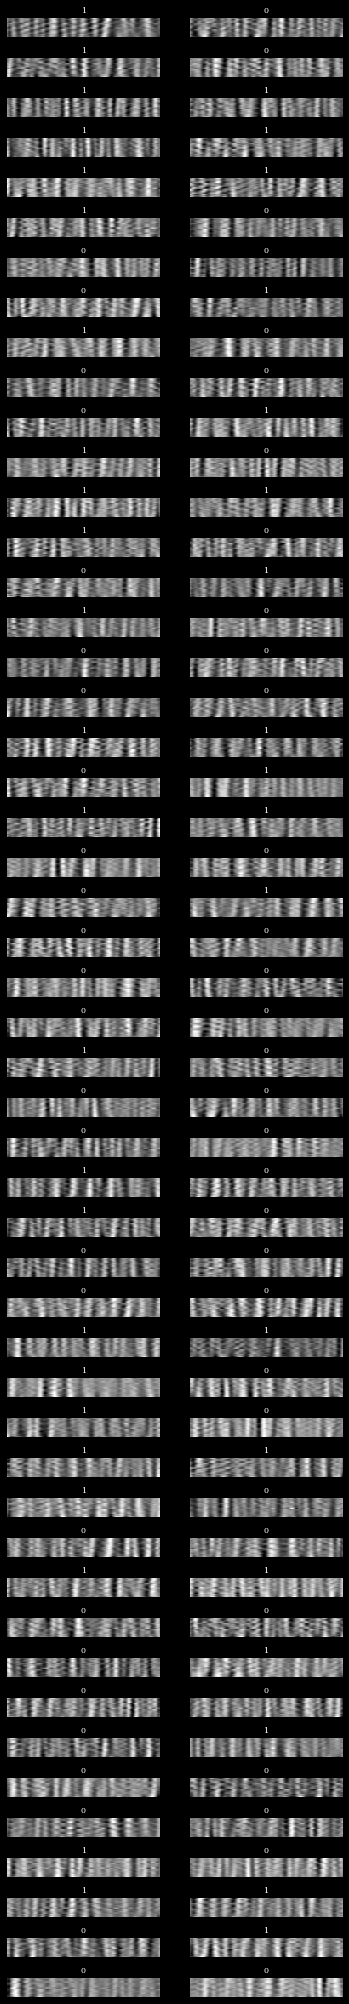

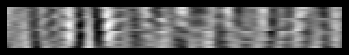

In [72]:
from matplotlib import pyplot as plt

# Visualization helpers.
kFigureWidth = 6
kSmallFigureWidth = 2

def PlotSample(sample, labels, image_width=22, image_height=180):
    """
    Plots sample if images on the grid. Stolen from the provided code.
    
    Parameters:
        
        sample: ndarray of images to plot, 2d array. Images are stored
                as flat array.
        
        image_width: width to reshape to the image before plotting *.
        
        image_hight: hight to reshape to the image before plotting *.
        
    *: or maybe other way around, I'm not going to check.
    """
    plt.style.use('dark_background')
    N = sample.shape[0]
    num_columns = 2
    num_row = (N + num_columns - 1) // num_columns
    fig = plt.figure(figsize=(kFigureWidth,
                              num_row * kFigureWidth / num_columns * image_width / image_height * 2))
    fig.tight_layout()
    for n in range(N):
        ax = fig.add_subplot((N + num_columns - 1) // num_columns, num_columns, n + 1)
        ax.imshow(sample[n],
                   interpolation="None",
                   cmap='gray')
        ax.set_title(f'{labels[n]:.0f}', fontsize=8) 
        ax.axis('off')
    plt.show()

def PlotImage(image, title=None, image_width=22, image_height=180):
    """
    Plots image. Stolen from the provided code.
    
    Parameters:
        
        image: flat array
        
        title: if provided, title for plot to display.
        
        image_width: width to reshape to the image before plotting *.
        
        image_hight: hight to reshape to the image before plotting *.
    
    """
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(kFigureWidth, kFigureWidth))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(image,
              interpolation="None",
              cmap='gray')
    ax.axis('off')
    if title:
        ax.set_title(title)
    plt.show()

PlotSample(dat['xtrain'][0:100], dat['ytrain'][0:100])
PlotImage(dat['xtest'][1])



In [79]:
print(dat['xtrain'].max(), dat['xtrain'].min())
print(dat['xtest'].max(), dat['xtest'].min())
print(dat['xvalid'].max(), dat['xvalid'].min())

tensor(0.0572, dtype=torch.float64) tensor(-0.0524, dtype=torch.float64)
tensor(3.2649e-05, dtype=torch.float64) tensor(-2.9668e-05, dtype=torch.float64)
tensor(2.4774e-05, dtype=torch.float64) tensor(-2.9971e-05, dtype=torch.float64)


In [22]:
iter(unsup_trainloader).next()

RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

In [15]:

# # Main training loop CIFAR10
device = torch.device('cuda:0')
model = DeepSoftHebb()
model.to(device)

unsup_optimizer = TensorLRSGD([
    {"params": model.conv1.parameters(), "lr": -0.08, },  # SGD does descent, so set lr to negative
    {"params": model.conv2.parameters(), "lr": -0.005, },
    {"params": model.conv3.parameters(), "lr": -0.01, },
], lr=0)
unsup_lr_scheduler = WeightNormDependentLR(unsup_optimizer, power_lr=0.5)

sup_optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
sup_lr_scheduler = CustomStepLR(sup_optimizer, nb_epochs=50)
criterion = nn.CrossEntropyLoss()

trainset = FastCIFAR10('./data', train=True, download=True, device=device)
unsup_trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, )
sup_trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, )

testset = FastCIFAR10('./data', train=False, device=device)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)
    

# sup_optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# sup_lr_scheduler = CustomStepLR(sup_optimizer, nb_epochs=50)

# sup_optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# sup_lr_scheduler = CustomStepLR(sup_optimizer, nb_epochs=50)
# criterion = nn.CrossEntropyLoss()

# trainset = FastCIFAR10('./data', train=True, download=True)
# #     trainset = SimpleEEGDataset(dat['xtrain'], dat['ytrain'])
# unsup_trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
# sup_trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

# testset = FastCIFAR10('./data', train=False)
# # testset = SimpleEEGDataset(dat['xtest'], dat['ytest'])
# testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

    # Unsupervised training with SoftHebb
running_loss = 0.0
# for i, data in enumerate(unsup_trainloader, 0):
#     inputs, _ = data
#     inputs = inputs.to(device)

#     # zero the parameter gradients
#     unsup_optimizer.zero_grad()

#     # forward + update computation
#     with torch.no_grad():
#         outputs = model(inputs)

#     # optimize
#     unsup_optimizer.step()
#     unsup_lr_scheduler.step()

# # Supervised training of classifier
# # set requires grad false and eval mode for all modules but classifier
# unsup_optimizer.zero_grad()
# model.conv1.requires_grad = False
# model.conv2.requires_grad = False
# model.conv3.requires_grad = False
# model.conv1.eval()
# model.conv2.eval()
# model.conv3.eval()
# model.bn1.eval()
# model.bn2.eval()
# model.bn3.eval()
for epoch in range(50):
    model.classifier.train()
    model.dropout.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(sup_trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        sup_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        sup_optimizer.step()

        # compute training statistics
        running_loss += loss.item()
        if epoch % 10 == 0 or epoch == 49:
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    sup_lr_scheduler.step()
    # Evaluation on test set
    if epoch % 10 == 0 or epoch == 49:
        print(f'Accuracy of the network on the train images: {100 * correct // total} %')
        print(f'[{epoch + 1}] loss: {running_loss / total:.3f}')

        # on the test set
        model.eval()
        running_loss = 0.
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                # calculate outputs by running images through the network
                outputs = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                print(f'predicted: {predicted}')
                print(f'outputs: {outputs}')
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
        print(f'test loss: {running_loss / total:.3f}')

AttributeError: 'DeepSoftHebb' object has no attribute 'conv3'

In [ ]:
from torchsummary import summary


In [8]:
dat['xtrain'].device


device(type='cuda', index=0)

In [ ]:
print(summary(model, trainset[0][0].shape))

In [ ]:
from pynvml import *
import humanize
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {humanize.naturalsize(info.total)}')
print(f'free     : {humanize.naturalsize(info.free)}')
print(f'used     : {humanize.naturalsize(info.used)}')